# Voice Recognition Systems

##### Owen Kroeger
##### Tatum Hansen

## Setup and Imports

This cell sets up the environment by importing all necessary libraries and forcing TensorFlow to run on the CPU. It includes tools for data processing, feature extraction, model building, training, and evaluation.

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm  # Jupyter-compatible progress bar
from jiwer import wer  # Word Error Rate metric
import matplotlib.pyplot as plt
import librosa.display

# Force TensorFlow to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-01-26 20:21:58.535483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737948118.551519   36666 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737948118.556120   36666 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 20:21:58.571563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper Functions

This cell defines reusable helper functions for:

1. Converting the dataset from TSV to CSV.
2. Extracting audio features (MFCCs).
3. Splitting the data into training and testing sets.
4. Building RNN models (LSTM or GRU).
5. Calculating Word Error Rate (WER).

In [2]:
def tsv_to_csv(input_tsv, output_csv):
    """
    Converts a TSV file into a filtered CSV file for gender classification.

    Parameters:
    - input_tsv (str): Path to the input TSV file.
    - output_csv (str): Path to save the generated CSV file.

    Returns:
    - bool: True if CSV creation is successful, False otherwise.
    """
    try:
        # Check if the input TSV file exists
        if not os.path.exists(input_tsv):
            print(f"Input TSV file not found: {input_tsv}")
            return False
        
        # Read the TSV file into a pandas DataFrame
        data = pd.read_csv(input_tsv, sep='\t')

        # Remove rows with missing 'gender' values
        data = data.dropna(subset=['gender'])

        # Filter rows to include only specific gender categories
        data = data[data['gender'].isin(['female_feminine', 'male_masculine'])]

        # Select up to 2000 samples for each gender to balance the dataset
        female_data = data[data['gender'] == 'female_feminine'].head(2000)
        male_data = data[data['gender'] == 'male_masculine'].head(2000)

        # Combine the filtered data for both genders
        filtered_data = pd.concat([female_data, male_data])

        # Retain only the 'path' (audio file path) and 'gender' columns
        filtered_data = filtered_data[['path', 'gender']]

        # Save the filtered data to a CSV file
        filtered_data.to_csv(output_csv, index=False)
        print(f"CSV file created successfully: {output_csv}")
        return True
    except Exception as e:
        # Catch and print any errors during processing
        print(f"An error occurred: {e}")
        return False

def extract_features(file_path):
    """
    Extracts MFCC features from an audio file.

    Parameters:
    - file_path (str): Path to the audio file.

    Returns:
    - numpy.ndarray: Extracted MFCC features as a 1D array.
    - None: If an error occurs during feature extraction.
    """
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=None)

        # Compute MFCC (Mel Frequency Cepstral Coefficients)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

        # Return the mean MFCC features across time
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        # Catch and print errors during audio processing
        print(f"Error processing {file_path}: {e}")
        return None

def prepare_data(data_csv, audio_dir):
    """
    Prepares the dataset by extracting features and mapping labels.

    Parameters:
    - data_csv (str): Path to the CSV file containing audio paths and labels.
    - audio_dir (str): Directory containing the audio files.

    Returns:
    - tuple: (features, labels) as numpy arrays.
    """
    # Read the CSV file into a DataFrame
    data = pd.read_csv(data_csv)

    # Map gender labels to binary values: 'female_feminine' -> 0, 'male_masculine' -> 1
    data['gender'] = data['gender'].map({'female_feminine': 0, 'male_masculine': 1})

    features, labels = [], []
    print("Extracting features from audio files...")

    # Iterate through each row to extract features and labels
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Feature Extraction"):
        file_path = os.path.join(audio_dir, row['path'])
        if os.path.exists(file_path):
            feature = extract_features(file_path)
            if feature is not None:
                features.append(feature)
                labels.append(row['gender'])

    # Return features and labels as numpy arrays
    return np.array(features), np.array(labels)

def build_rnn_model(input_shape, model_type='LSTM'):
    """
    Builds an RNN model (LSTM or GRU) for binary classification.

    Parameters:
    - input_shape (tuple): Shape of the input features.
    - model_type (str): Type of RNN ('LSTM' or 'GRU').

    Returns:
    - tf.keras.Model: Compiled RNN model.
    """
    model = tf.keras.Sequential()
    if model_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.3))  # Dropout for regularization
    model.add(tf.keras.layers.LSTM(64))  # Second RNN layer
    model.add(tf.keras.layers.Dense(32, activation='relu'))  # Fully connected layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(features, labels, model_type='LSTM', batch_size=32, epochs=10):
    """
    Trains an RNN model on the given features and labels.

    Parameters:
    - features (numpy.ndarray): Feature array.
    - labels (numpy.ndarray): Label array.
    - model_type (str): Type of RNN ('LSTM' or 'GRU').
    - batch_size (int): Size of mini-batches during training.
    - epochs (int): Number of training epochs.

    Returns:
    - tuple: Trained model and training history.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Expand dimensions to match model input
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    # Build the model
    model = build_rnn_model(X_train.shape[1:], model_type)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size
    )

    # Evaluate the model on the test set
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, predictions))

    return model, history

def evaluate_wer(model, test_files):
    """
    Evaluate Word Error Rate (WER) for gender predictions on test files.

    Parameters:
    - model (tf.keras.Model): Trained model.
    - test_files (list): List of paths to test audio files.

    Returns:
    - float: WER score.
    """
    predictions, references = [], []

    for file_path in test_files:
        if os.path.exists(file_path):
            feature = extract_features(file_path)
            if feature is not None:
                feature = np.expand_dims(feature, axis=(0, -1))
                prediction = model.predict(feature)
                predicted_gender = "male" if prediction[0][0] > 0.5 else "female"
                predictions.append(predicted_gender)
                references.append("female" if "female" in file_path.lower() else "male")

    # Calculate WER
    return wer(references, predictions)

## Prepare Dataset

This cell converts the dataset from TSV to CSV, splits the data into training and testing sets, and extracts audio features.

In [3]:
# Define base directory containing the dataset
base_dir = "/mnt/c/users/okroe/Downloads/VoiceRecognitionDataset/cv-corpus-20.0-delta-2024-12-06/en"

# Define paths to the input TSV file (raw dataset) and audio directory
input_tsv = os.path.join(base_dir, "other.tsv")  # Path to the TSV file with metadata
audio_dir = os.path.join(base_dir, "clips")      # Directory containing audio clips

# Define the path for the output CSV file after processing
output_csv = "Gender.csv"  # CSV file that will store the filtered and formatted dataset

# Step 1: Convert TSV to CSV
if tsv_to_csv(input_tsv, output_csv):  # Attempt to convert and filter the dataset
    # Step 2: Extract features from audio files and prepare labels
    features, labels = prepare_data(output_csv, audio_dir)
else:
    # Print an error message if TSV to CSV conversion fails
    print("Dataset preparation failed.")

CSV file created successfully: Gender.csv
Extracting features from audio files...


Feature Extraction:   0%|          | 0/4000 [00:00<?, ?it/s]

## Train the Models

This cell trains two models: one using LSTM layers and another using GRU layers. Both models are trained on the training set and validated on the test set.

In [4]:
# Train LSTM Model
print("Training LSTM Model...")
lstm_model, lstm_history = train_model(features, labels, model_type="LSTM", epochs=10, batch_size=32)

# Train GRU Model
print("Training GRU Model...")
gru_model, gru_history = train_model(features, labels, model_type="GRU", epochs=10, batch_size=32)

Training LSTM Model...
Epoch 1/10


2025-01-26 20:28:16.595878: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/oskroeger/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8632 - loss: 0.3531 - val_accuracy: 0.9337 - val_loss: 0.1916
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9238 - loss: 0.1806 - val_accuracy: 0.9337 - val_loss: 0.1642
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9530 - loss: 0.1324 - val_accuracy: 0.9550 - val_loss: 0.1128
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9537 - loss: 0.1060 - val_accuracy: 0.9613 - val_loss: 0.0942
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9675 - loss: 0.0912 - val_accuracy: 0.9650 - val_loss: 0.0934
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9639 - loss: 0.0900 - val_accuracy: 0.9575 - val_loss: 0.1017
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9520 - loss: 0.1192 - val_accuracy: 0.9638 - val_loss: 0.0946
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9720 - loss: 0.0723 - val_accuracy: 0.961

/home/oskroeger/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8369 - loss: 0.3840 - val_accuracy: 0.9162 - val_loss: 0.1824
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9421 - loss: 0.1550 - val_accuracy: 0.9463 - val_loss: 0.1373
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9556 - loss: 0.1213 - val_accuracy: 0.9500 - val_loss: 0.1258
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9629 - loss: 0.1049 - val_accuracy: 0.9550 - val_loss: 0.1161
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9536 - loss: 0.1123 - val_accuracy: 0.9675 - val_loss: 0.0923
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9671 - loss: 0.0815 - val_accuracy: 0.9312 - val_loss: 0.1421
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9519 - loss: 0.1142 - val_accuracy: 0.9625 - val_loss: 0.1048
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9694 - loss: 0.0689 - val_accuracy: 0.967

## Plot the Results

This cell and the WER cell evaluates both models on the test set, generating a classification report and calculating the Word Error Rate (WER) for each model.

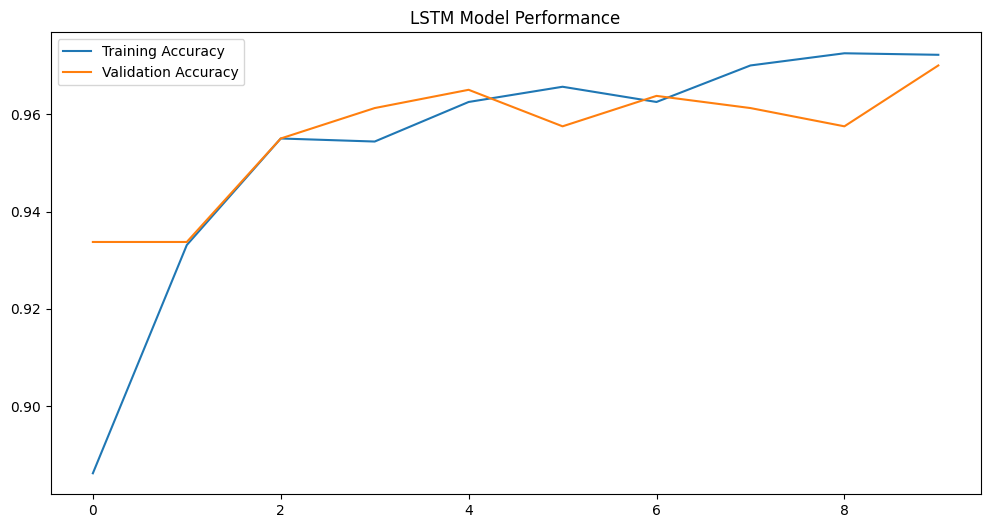

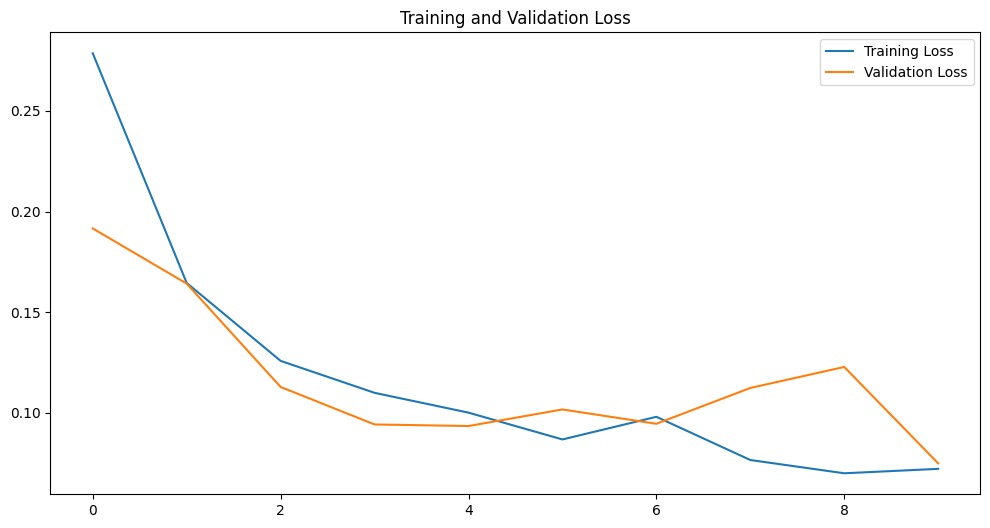

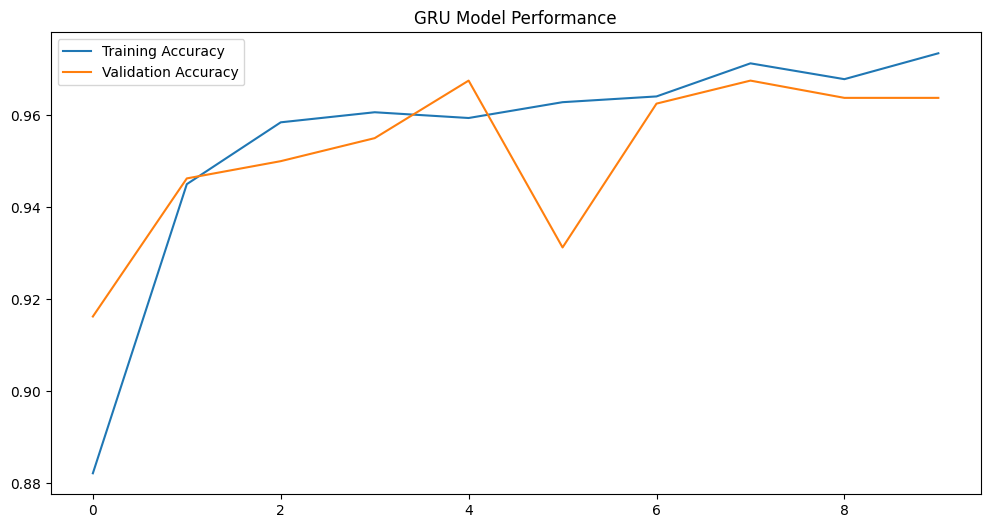

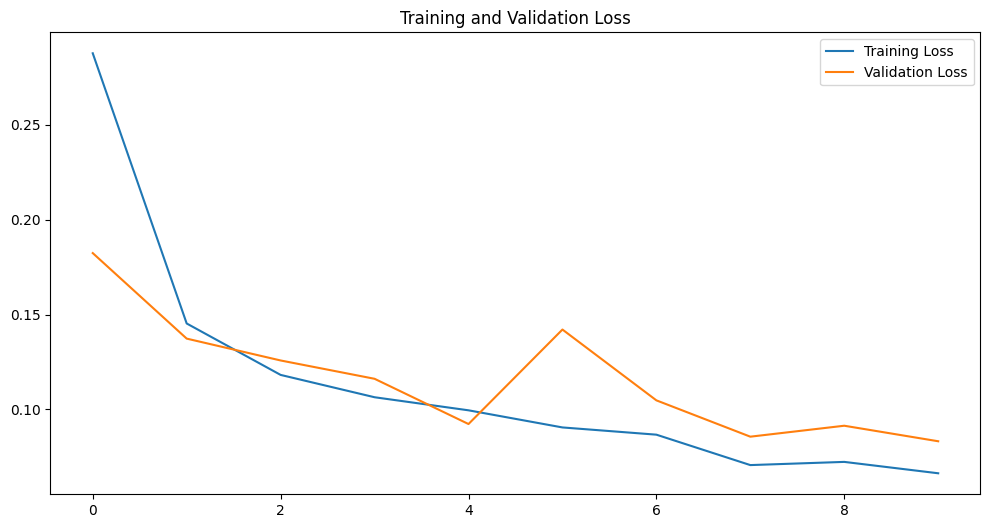

In [6]:
def plot_training(history, title="Training and Validation Accuracy"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Plot LSTM results
plot_training(lstm_history, "LSTM Model Performance")

# Plot GRU results
plot_training(gru_history, "GRU Model Performance")

## Calculate WER

In [8]:
# Define test files
test_files = [
    os.path.join(base_dir, "clips", "common_voice_en_41796472.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41796474.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595170.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595171.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595172.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595173.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595174.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595145.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595146.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595152.mp3"),
    os.path.join(base_dir, "clips", "common_voice_en_41595153.mp3")
]

# Evaluate WER for LSTM
print("\nEvaluating WER for LSTM Model...")
lstm_wer = evaluate_wer(lstm_model, test_files)
print(f"LSTM WER: {lstm_wer:.2f}")

# Evaluate WER for GRU
print("\nEvaluating WER for GRU Model...")
gru_wer = evaluate_wer(gru_model, test_files)
print(f"GRU WER: {gru_wer:.2f}")


Evaluating WER for LSTM Model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM WER: 0.09

Evaluating WER for GRU Model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GRU WER: 0.00
